# Facial Emotion Recognition

## Preperations

### Import libraries

In [42]:
import cv2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [43]:
face_cascade = cv2.CascadeClassifier('../Data/haarcascade_frontalface_default.xml')

### Functions for image loading and feature extraction

In [44]:
def load_and_detect_faces(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w] # Crop to face region
                        images.append(face_region)
                        labels.append(label)
                        images.append(cv2.flip(face_region, 1))
                        labels.append(label)
    return images, labels

In [45]:
radius = 1
n_points = 8 * radius

def extract_lbp_features(images):
    lbp_features = []
    for img in images:

        img = cv2.resize(img, (64, 64))
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')

        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.append(hist)
    return np.array(lbp_features)

In [46]:
def extract_hog_features(images):
    hog_features = []

    pixels_per_cell = (10, 10)
    cells_per_block = (2,2)
    orientations = 9

    for img in images:

        img = cv2.resize(img, (80, 80))

        features = hog(
            img,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True
        )
        hog_features.append(features)

    return np.array(hog_features)

### Load and prepare images

In [47]:
ck_folder_path = "../Data/assignment/CK_dataset"
jaffe_folder_path = "../Data/assignment/jaffe"

ck_images, ck_labels = load_and_detect_faces(ck_folder_path)
jaffe_images, jaffe_labels = load_and_detect_faces(jaffe_folder_path)


ck_lbp_features = extract_lbp_features(ck_images)
jaffe_lbp_features = extract_lbp_features(jaffe_images)

ck_hog_features = extract_hog_features(ck_images)
jaffe_hog_features = extract_hog_features(jaffe_images)

all_lbp_features = np.concatenate((ck_lbp_features, jaffe_lbp_features), axis=0)
all_hog_features = np.concatenate((ck_hog_features, jaffe_hog_features), axis=0)

x = np.concatenate((all_lbp_features, all_hog_features), axis=1)
y = np.array(ck_labels + jaffe_labels)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# x_train, x_test, y_train, y_test = train_test_split(all_hog_features, y, test_size=0.2, random_state=42)

# x_train, x_test, y_train, y_test = train_test_split(np.concatenate((ck_lbp_features, ck_hog_features), axis=1), ck_labels, test_size=0.2, random_state=42)

# x_train, x_test, y_train, y_test = train_test_split(ck_hog_features, ck_labels, test_size=0.2, random_state=42)

# x_train, x_test, y_train, y_test = train_test_split(np.concatenate((jaffe_lbp_features, jaffe_hog_features), axis=1), jaffe_labels, test_size=0.2, random_state=42)

In [48]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1080, 1774), (270, 1774), (1080,), (270,))

## Train models and analyse performance

### K-nearest Neighbors (KNN)

In [49]:
from sklearn.neighbors import KNeighborsClassifier

k = 15

# knn = KNeighborsClassifier(5)
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
knn.fit(x_train, y_train)

y_train_pred = knn.predict(x_train)
y_test_pred = knn.predict(x_test)

# Training set performance
knn_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
knn_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
knn_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
knn_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
knn_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
knn_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % knn_train_accuracy)
print('- MCC: %s' % knn_train_mcc)
print('- F1 score: %s' % knn_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % knn_test_accuracy)
print('- MCC: %s' % knn_test_mcc)
print('- F1 score: %s' % knn_test_f1)

Model performance for Training set
- Accuracy: 0.6564814814814814
- MCC: 0.5906756302574118
- F1 score: 0.649982545621022
----------------------------------
Model performance for Test set
- Accuracy: 0.6074074074074074
- MCC: 0.541660309915554
- F1 score: 0.5920789343529457


In [50]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(len(y_test))
print(conf_matrix)

270
[[18  0  0 17  3  0]
 [ 2  2  1 13  1  2]
 [ 0  0 50 12  0  0]
 [ 1  0  0 48  0  5]
 [ 7  0  3 20  7  0]
 [ 0  1  2 16  0 39]]


### Support Vector Machine (SVM)

In [51]:
from sklearn.decomposition import PCA

n_components = 1

svm_rbf = make_pipeline(
    StandardScaler(),
    PCA(n_components=40),
    OneVsRestClassifier(SVC(kernel='rbf', C=0.45, gamma='scale'))
)
svm_rbf.fit(x_train, y_train)

y_train_pred = svm_rbf.predict(x_train)
y_test_pred = svm_rbf.predict(x_test)

# Training set performance
svm_rbf_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
svm_rbf_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
svm_rbf_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
svm_rbf_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
svm_rbf_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
svm_rbf_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % svm_rbf_train_accuracy)
print('- MCC: %s' % svm_rbf_train_mcc)
print('- F1 score: %s' % svm_rbf_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % svm_rbf_test_accuracy)
print('- MCC: %s' % svm_rbf_test_mcc)
print('- F1 score: %s' % svm_rbf_test_f1)

Model performance for Training set
- Accuracy: 0.8527777777777777
- MCC: 0.8199778754989957
- F1 score: 0.8502243121928369
----------------------------------
Model performance for Test set
- Accuracy: 0.7518518518518519
- MCC: 0.6968691642995507
- F1 score: 0.7485866101349187


In [52]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(len(y_test))
print(conf_matrix)

270
[[31  0  0  4  3  0]
 [ 0  9  0  5  2  5]
 [ 0  0 56  6  0  0]
 [ 5  0  0 41  2  6]
 [ 7  0  5  5 20  0]
 [ 1  0  2  9  0 46]]


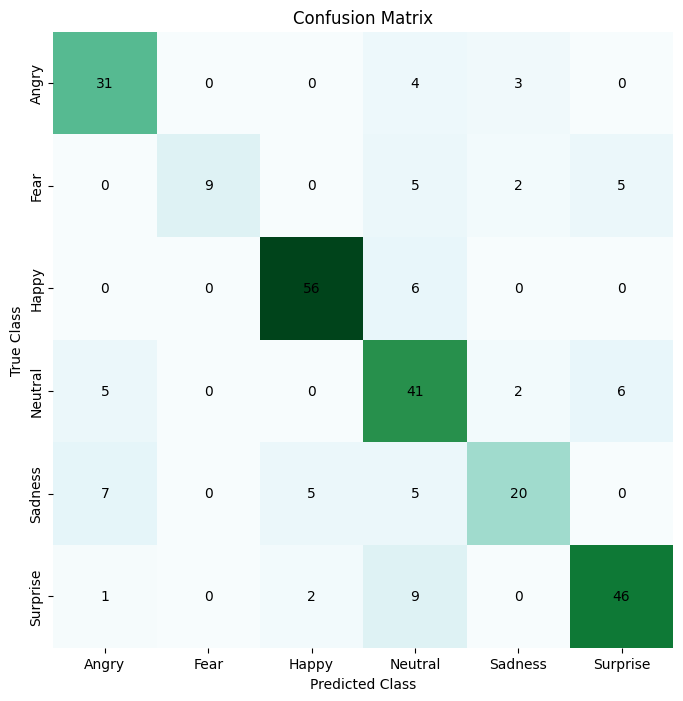

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

conf_matrix = confusion_matrix(y_test, y_test_pred)

conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(8,8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")

plt.savefig(f"ConfusionMatrix_SVM.png", dpi=300)

plt.show()

### Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(x_train, y_train)

y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)

# Training set performance
dt_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
dt_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
dt_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
dt_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
dt_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
dt_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % dt_train_accuracy)
print('- MCC: %s' % dt_train_mcc)
print('- F1 score: %s' % dt_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % dt_test_accuracy)
print('- MCC: %s' % dt_test_mcc)
print('- F1 score: %s' % dt_test_f1)

Model performance for Training set
- Accuracy: 0.637962962962963
- MCC: 0.5587674199368636
- F1 score: 0.6440628991156667
----------------------------------
Model performance for Test set
- Accuracy: 0.4925925925925926
- MCC: 0.38287583114700335
- F1 score: 0.5036732167774584


In [55]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(len(y_test))
print(conf_matrix)

270
[[10  5  1 13  7  2]
 [ 0  7  0  9  1  4]
 [ 2  2 47  8  1  2]
 [10  2  2 25 12  3]
 [ 7  3  2  8 14  3]
 [ 3  5  2 14  4 30]]


### Random Forest

In [56]:
rf = rf = RandomForestClassifier(max_depth=4, min_samples_leaf=16, random_state=42)
rf.fit(x_train, y_train)

y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

# Training set performance
rf_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
rf_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
rf_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
rf_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
rf_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
rf_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % rf_train_accuracy)
print('- MCC: %s' % rf_train_mcc)
print('- F1 score: %s' % rf_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % rf_test_accuracy)
print('- MCC: %s' % rf_test_mcc)
print('- F1 score: %s' % rf_test_f1)

Model performance for Training set
- Accuracy: 0.5861111111111111
- MCC: 0.5197595992470184
- F1 score: 0.5071346438890155
----------------------------------
Model performance for Test set
- Accuracy: 0.5259259259259259
- MCC: 0.45089461869142267
- F1 score: 0.4478230575158091


In [57]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(len(y_test))
print(conf_matrix)

270
[[ 0  0  2 34  1  1]
 [ 0  0  2  7  0 12]
 [ 0  0 54  8  0  0]
 [ 0  0  0 47  0  7]
 [ 0  0  1 35  1  0]
 [ 0  0  2 16  0 40]]


### Testing with stacking the models

In [58]:
estimator_list = [
    ('knn',knn),
    # ('svm_rbf',svm_rbf),
    ('dt',dt),
    ('rf',rf)
    ]

stack_model = StackingClassifier(
    estimators=estimator_list,
    final_estimator=LogisticRegression(C=0.2, solver='liblinear', random_state=42)
)

stack_model.fit(x_train, y_train)

y_train_pred = stack_model.predict(x_train)
y_test_pred = stack_model.predict(x_test)

# Training set model performance
stack_model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
stack_model_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
stack_model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set model performance
stack_model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
stack_model_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
stack_model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % stack_model_train_accuracy)
print('- MCC: %s' % stack_model_train_mcc)
print('- F1 score: %s' % stack_model_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % stack_model_test_accuracy)
print('- MCC: %s' % stack_model_test_mcc)
print('- F1 score: %s' % stack_model_test_f1)

Model performance for Training set
- Accuracy: 0.6935185185185185
- MCC: 0.6334318510701293
- F1 score: 0.6663214694537362
----------------------------------
Model performance for Test set
- Accuracy: 0.6370370370370371
- MCC: 0.5646604049024716
- F1 score: 0.6064144540578232


C:\Users\sarah\source\repos\UCLan_ArtificialIntelligence\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [59]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(len(y_test))
print(conf_matrix)

270
[[17  0  1 15  4  1]
 [ 0  0  0 10  4  7]
 [ 0  0 54  6  0  2]
 [ 1  0  2 47  0  4]
 [ 6  0  2 16 11  2]
 [ 0  0  3 12  0 43]]


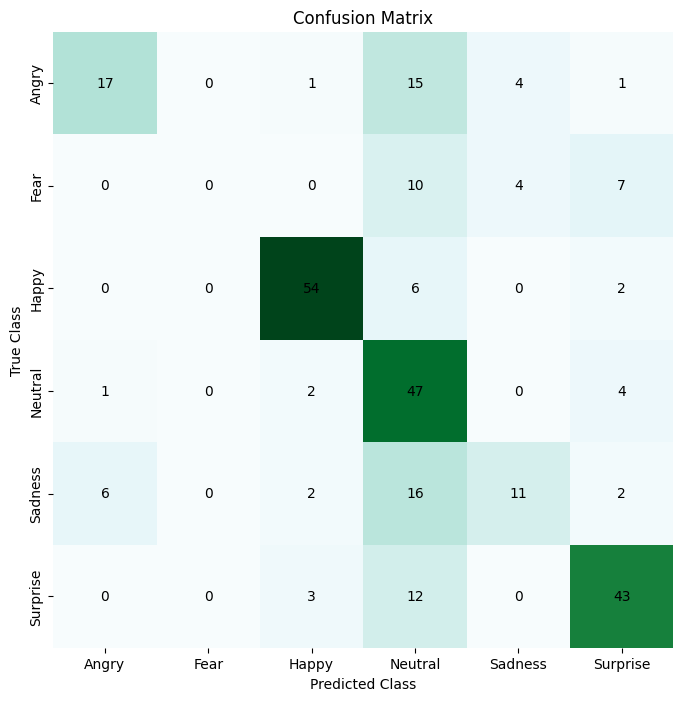

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

conf_matrix = confusion_matrix(y_test, y_test_pred)

conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(8,8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

## Displaying performance data

In [61]:
acc_train_list = {
    'knn':knn_train_accuracy,
    'svm_rbf': svm_rbf_train_accuracy,
    'dt': dt_train_accuracy,
    'rf': rf_train_accuracy,
    'stack': stack_model_train_accuracy
}

mcc_train_list = {
    'knn':knn_train_mcc,
    'svm_rbf': svm_rbf_train_mcc,
    'dt': dt_train_mcc,
    'rf': rf_train_mcc,
    'stack': stack_model_train_mcc
}

f1_train_list = {
    'knn':knn_train_f1,
    'svm_rbf': svm_rbf_train_f1,
    'dt': dt_train_f1,
    'rf': rf_train_f1,
    'stack': stack_model_train_f1
}

acc_test_list = {
    'knn':knn_test_accuracy,
    'svm_rbf': svm_rbf_test_accuracy,
    'dt': dt_test_accuracy,
    'rf': rf_test_accuracy,
    'stack': stack_model_test_accuracy
}

mcc_test_list = {
    'knn':knn_test_mcc,
    'svm_rbf': svm_rbf_test_mcc,
    'dt': dt_test_mcc,
    'rf': rf_test_mcc,
    'stack': stack_model_test_mcc
}

f1_test_list = {
    'knn':knn_test_f1,
    'svm_rbf': svm_rbf_test_f1,
    'dt': dt_test_f1,
    'rf': rf_test_f1,
    'stack': stack_model_test_f1
}

In [62]:
acc_df_train = pd.DataFrame.from_dict(acc_train_list, orient='index', columns=['Accuracy Train'])
mcc_df_train = pd.DataFrame.from_dict(mcc_train_list, orient='index', columns=['MCC Train'])
f1_df_train = pd.DataFrame.from_dict(f1_train_list, orient='index', columns=['F1 Train'])
acc_df_test = pd.DataFrame.from_dict(acc_test_list, orient='index', columns=['Accuracy Test'])
mcc_df_test = pd.DataFrame.from_dict(mcc_test_list, orient='index', columns=['MCC Test'])
f1_df_test = pd.DataFrame.from_dict(f1_test_list, orient='index', columns=['F1 Test'])
df = pd.concat([acc_df_train, mcc_df_train, f1_df_train, acc_df_test, mcc_df_test, f1_df_test], axis=1)
df

Accuracy Train  MCC Train  F1 Train  Accuracy Test  MCC Test  \
knn            0.656481   0.590676  0.649983       0.607407  0.541660   
svm_rbf        0.852778   0.819978  0.850224       0.751852  0.696869   
dt             0.637963   0.558767  0.644063       0.492593  0.382876   
rf             0.586111   0.519760  0.507135       0.525926  0.450895   
stack          0.693519   0.633432  0.666321       0.637037  0.564660   

          F1 Test  
knn      0.592079  
svm_rbf  0.748587  
dt       0.503673  
rf       0.447823  
stack    0.606414

In [63]:
df.to_csv('results.csv')

## Testing best performance model

### Function for predicting saved images

--- Running Example ---


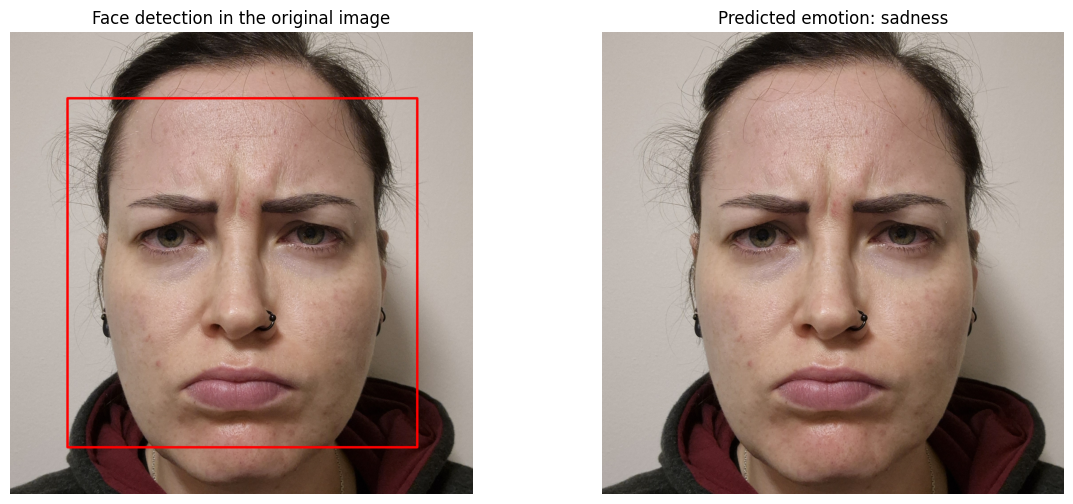

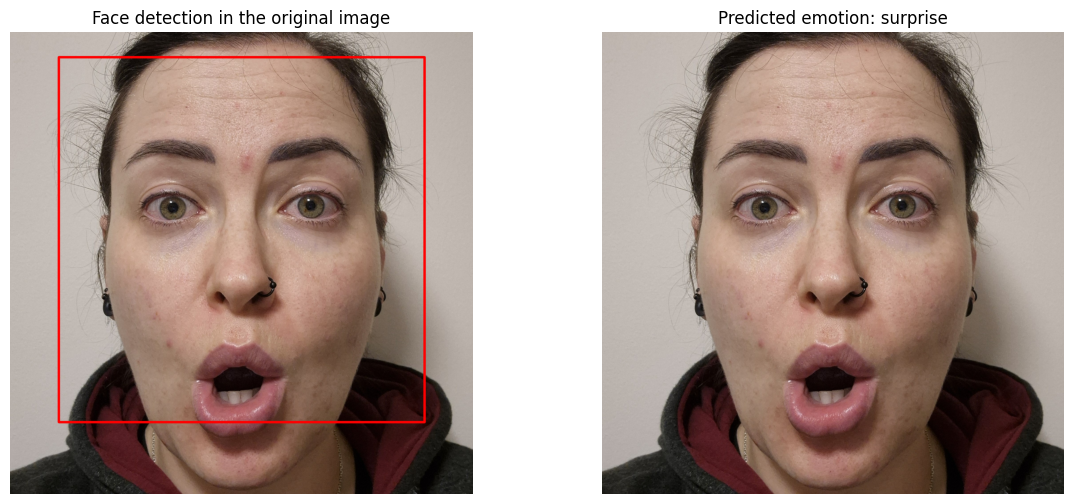

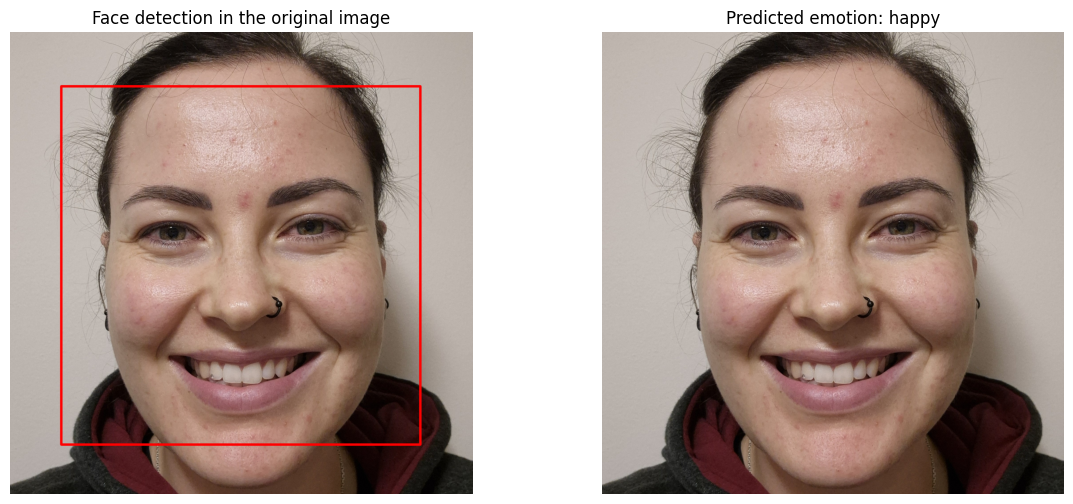

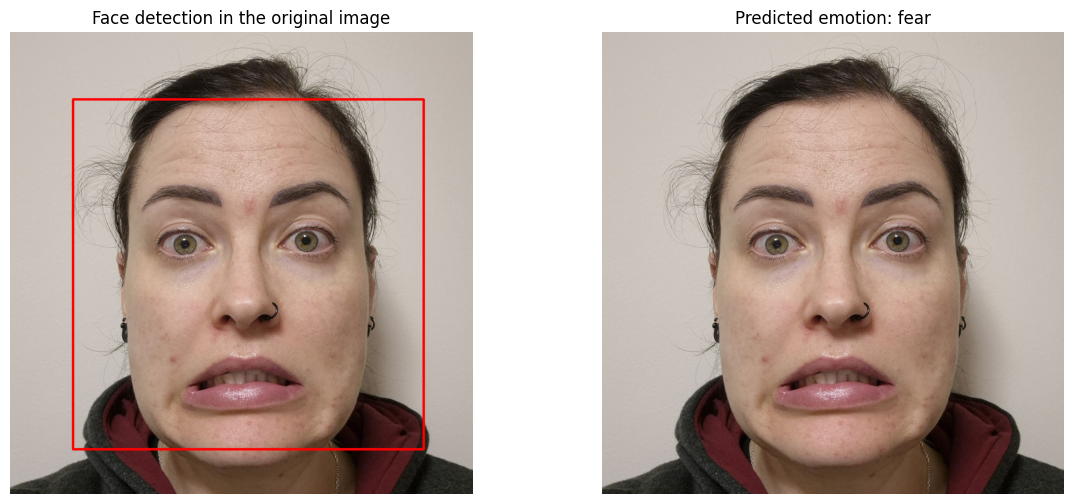

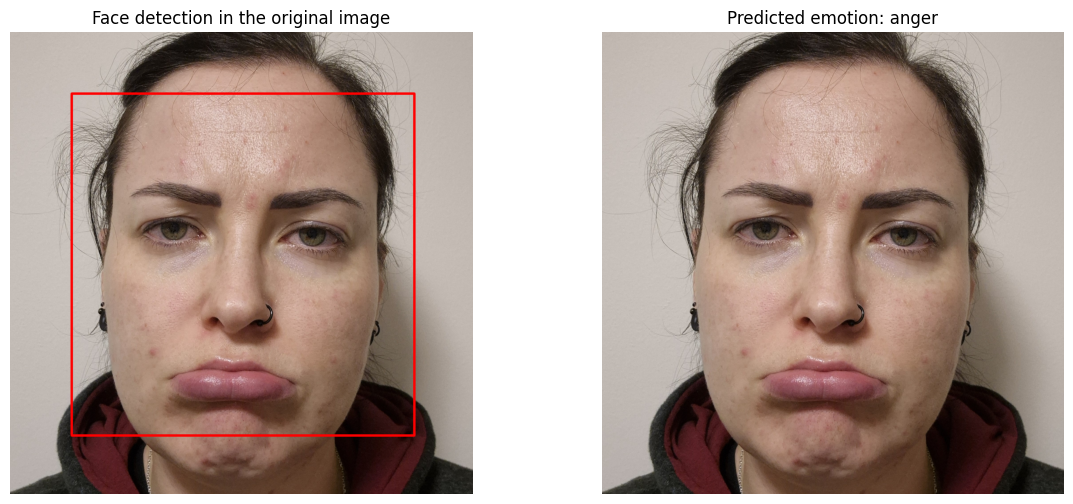

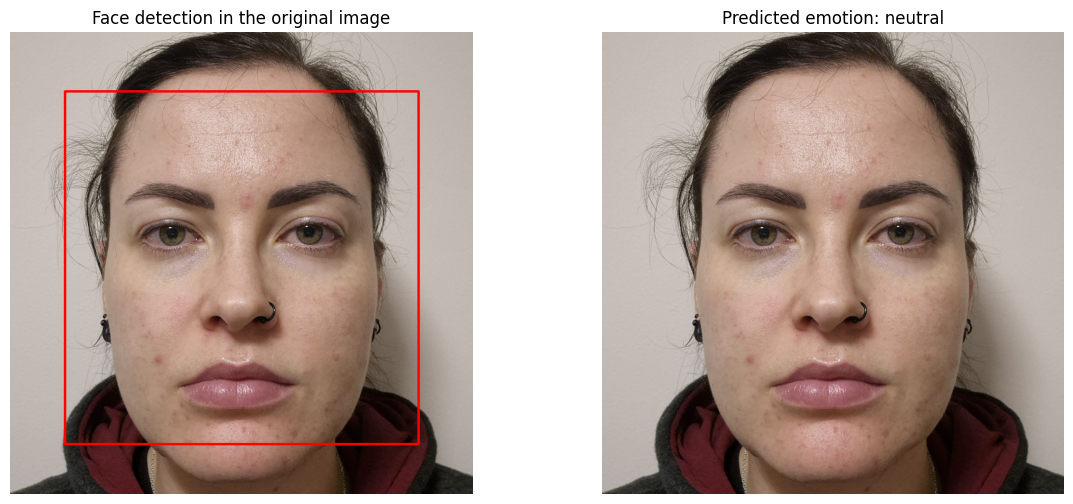

--- Execution Complete ---


In [64]:
def predict_emotion(image_path, model):

    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    orientations = 9
    standard_size = (64, 64)

    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    if img is None:
        print("Image not found or could not be loaded.")
        return

    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    for (x, y, w, h) in faces:

        face_region = img[y:y+h, x:x+w]

        processed_face = cv2.resize(face_region, standard_size)

        # --- LBP Feature Extraction ---
        lbp = local_binary_pattern(processed_face, n_points, radius, method='uniform')
        (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)

        # --- HOG Feature Extraction ---
        hog_features = hog(
            processed_face,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            transform_sqrt=True,
            feature_vector=True # Returns a 1D vector
        )


        combined_features = np.hstack([lbp_hist, hog_features])

        feature_vector_for_prediction = combined_features.reshape(1, -1)

        prediction = model.predict(feature_vector_for_prediction)[0]

        img_rgb = cv2.imread(image_path)

        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

        img_with_box = img_rgb.copy()
        cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (255, 0, 0), 10)

        plt.figure(figsize = (14, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(img_with_box)
        plt.title(f"Face detection in the original image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img_rgb)
        plt.title(f"Predicted emotion: {prediction}")
        plt.axis('off')

        plt.savefig(f"DetectionAndPrediction_{prediction}.png", dpi=300)

        plt.show()

try:
    print("--- Running Example ---")
    predict_emotion('./TestData/20251201_195843.jpg', svm_rbf)
    predict_emotion('./TestData/20251201_195840.jpg', svm_rbf)
    predict_emotion('./TestData/20251201_195833.jpg', svm_rbf)
    predict_emotion('./TestData/20251201_210129.jpg', svm_rbf)
    predict_emotion('./TestData/20251201_210228.jpg', svm_rbf)
    predict_emotion('./TestData/20251201_210237.jpg', svm_rbf)
    print("--- Execution Complete ---")
except Exception as e:
    print(f"Error message: {e}")

In [65]:
# def live_emotion_detection(model):
#
#     pixels_per_cell = (10, 10)
#     cells_per_block = (2, 2)
#     orientations = 9
#     standard_size = (80, 80)
#
#     cap = cv2.VideoCapture(0)
#
#     if not cap.isOpened():
#         print("Error: Could not open webcam. Check camera connection and permissions.")
#         return
#
#     print("Webcam started. Press 'q' to exit the live detection window.")
#
#     try:
#         while True:
#             ret, frame = cap.read()
#             if not ret:
#                 print("Error: Could not read frame from webcam.")
#                 break
#
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#
#             faces = face_cascade.detectMultiScale(
#                 gray_frame,
#                 scaleFactor=1.1,
#                 minNeighbors=5,
#                 minSize=(30, 30)
#             )
#
#             display_frame = frame.copy()
#             for (x, y, w, h) in faces:
#                 face_region = gray_frame[y:y+h, x:x+w]
#
#                 if face_region.shape[0] == 0 or face_region.shape[1] == 0:
#                     continue
#
#                 processed_face = cv2.resize(face_region, standard_size)
#
#                 # --- LBP Feature Extraction ---
#                 lbp = local_binary_pattern(processed_face, n_points, radius, method='uniform')
#                 (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
#                 lbp_hist = lbp_hist.astype("float")
#                 lbp_hist /= (lbp_hist.sum() + 1e-6)
#
#                 # --- HOG Feature Extraction ---
#                 hog_features = hog(
#                     processed_face,
#                     orientations=orientations,
#                     pixels_per_cell=pixels_per_cell,
#                     cells_per_block=cells_per_block,
#                     block_norm='L2-Hys',
#                     transform_sqrt=True,
#                     feature_vector=True
#                 )
#
#                 combined_features = np.hstack([lbp_hist, hog_features])
#                 feature_vector_for_prediction = combined_features.reshape(1, -1)
#
#                 prediction_probas = model.predict(feature_vector_for_prediction)[0]
#
#
#                 cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
#
#                 label = prediction_probas
#
#                 font = cv2.FONT_HERSHEY_SIMPLEX
#                 text_scale = 0.7
#                 text_thickness = 2
#
#                 text_size = cv2.getTextSize(label, font, text_scale, text_thickness)[0]
#
#                 text_x = x
#                 text_y = y - 10 if y - 10 > 10 else y + h + text_size[1]
#
#                 cv2.rectangle(display_frame, (text_x, text_y - text_size[1] - 5),
#                               (text_x + text_size[0] + 5, text_y), (0, 255, 0), -1)
#
#                 cv2.putText(display_frame, label, (text_x + 2, text_y - 2), font, text_scale, (0, 0, 0), text_thickness, cv2.LINE_AA)
#
#             cv2.imshow('Live Emotion Detection (Press Q to quit)', display_frame)
#
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
#
#     finally:
#         cap.release()
#         cv2.destroyAllWindows()
#
# if __name__ == "__main__":
#     print("--- Starting Live Webcam Detection ---")
#     live_emotion_detection(svm_rbf)
#     print("--- Webcam Detection Stopped ---")